In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
import numpy as np
import json
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
import pickle
import pandas as pd

from collections import defaultdict

In [3]:
# this defines all of the default colors and markers for the plots
# keys = ['bananas/bananas', 'hb', 'ls', 'rs', 're', 'ls_svr', 'rea_svr', 'bananas_svr/bananas']
# predictors = ['hb', 'bohb', 'ls', 'bananas', 're', 'npenas', 'dehb', 'rs', 'sh', ]
predictors = ['ls', 'bananas', 're', 'rs', 'bohb', 'dehb', 'hb', 'sh', 'npenas']
benchmark_datasets = ['cifar10', 'cifar100', 'ImageNet16-120', ]
# benchmark_datasets = ['ImageNet16-120', ]
# TODO: What of this am I really needing?
defaults = [(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
            (1.0, 0.4980392156862745, 0.054901960784313725),
            (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
            (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
            (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
            (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
            (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
            (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
            (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
            (0.09019607843137255, 0.7450980392156863, 0.8117647058823529),
            (0.0, 0.0, 0.0),
            (0.7058823529411765, 0.12156862745098039, 0.4666666666666667),
            (0.4666666666666667, 0.8901960784313725, 0.7607843137254902,),
           ]

fmts = ['-', '--', ':']
markers = ['^', 'v', 'o']
defaults = [np.array(d) for d in defaults]

# 
pred_plot_dict={
    'ls':{'color':defaults[0], 'fmt':fmts[0]},
    # 'ls_lce':{'color':defaults[0], 'fmt':fmts[1]},
    # 'ls_svr':{'color':defaults[0], 'fmt':fmts[2]},
    're':{'color':defaults[1], 'fmt':fmts[2]},
    # 'rea_lce':{'color':defaults[1], 'fmt':fmts[1]},
    # 'rea_svr':{'color':defaults[1], 'fmt':fmts[2]},
    'bananas/bananas':{'color':defaults[2], 'fmt':fmts[0]},
    'bananas':{'color':defaults[2], 'fmt':fmts[0]},
    # 'bananas_lce/bananas':{'color':defaults[2], 'fmt':fmts[1]},
    # 'bananas_svr/bananas':{'color':defaults[2], 'fmt':fmts[2]},    
    'rs':{'color':defaults[3], 'fmt':fmts[0]},
    'sh': {'color': defaults[1], 'fmt':fmts[0]},
    'hb':{'color':defaults[4], 'fmt':fmts[0]},
    'bohb':{'color':defaults[5], 'fmt':fmts[0]},
    'dehb':{'color':defaults[6], 'fmt':fmts[2]},
    'npenas':{'color':defaults[0], 'fmt':fmts[1]},
}

# define colors, formats, and markers
c_max = 10
colors = [*defaults[:c_max], *defaults[:c_max], *defaults[:c_max]]
fmts = [*['-']*c_max, *['--']*c_max, *[':']*c_max]
markers = [*['^']*c_max, *['v']*c_max, *['o']*c_max]

# https://matplotlib.org/2.1.2/api/_as_gen/matplotlib.pyplot.plot.html

# some of them are not used
pred_label_dict={
    'bananas/gcn':'BANANAS-GCN', 'bananas':'BANANAS', 'bananas/xgb':'BANANAS-XGB', 
    'npenas/gcn':'NPENAS-GCN', 'npenas/bananas':'NPENAS-BANANAS', 'npenas/xgb':'NPENAS-XGB', 
    'rs':'RS',
    're': 'RE',
    'ls': 'LS',
    'hb': 'HB',
    'sh': 'SH',
    'bohb': 'BOHB',
    'dehb': 'DEHB',
    'rea_svr': 'REA-SVR',
    'bananas_svr/bananas':'BANANAS-SVR',
    'rea_lce': 'REA-WPM',
    'bananas_lce/bananas':'BANANAS-WPM',
    'ls_svr': 'LS-SVR',
    'ls_lce': 'LS-WPM',
    'ls_svr_hp': 'LS-SVR-HP',
    'rea_svr_hp': 'REA-SVR-HP',
    'bananas_svr_hp/bananas': 'BANANAS-SVR-HP',
    'npenas': 'NPENAS',
}

val_gts = {'cifar10': 91.61, 
           'cifar100': 73.49, 
           'ImageNet16-120': 50.0, 
           'nasbench311': 95.8, 
           'nasbench111':95.6, 
           'nasbenchnlp':100.7}

datasets = {'cifar10': 'cifar10',
           'cifar100': 'cifar100', 
           'ImageNet16-120': 'ImageNet16-120', 
           'nasbench311': 'cifar10', 
           'nasbench111':'cifar10', 
           'nasbenchnlp':'ptb'
           }

In [4]:
def merge_and_fill_trajectories(pandas_data_frames, default_value=None):
    # merge all trajectories keeping all time steps
    df = pd.DataFrame().join(pandas_data_frames, how='outer')

    # forward fill to make it a propper step function
    df = df.fillna(method='ffill')
    if default_value is None:
        # backward fill to replace the NaNs for the early times by the
        # performance of a random configuration
        df = df.fillna(method='bfill')
    else:
        df = df.fillna(default_value)
    return df

In [5]:
def get_trajectories(losses, iterations):
    dfs = []
    for i in range(len(losses)):
        loss = losses[i]
        iteration = iterations[i]
        # print('Run %d, Min: %f'%(i, loss))
        df = pd.DataFrame({str(i): loss}, index=iteration)
        dfs.append(df)

    df = merge_and_fill_trajectories(dfs, default_value=None)

    return np.array(df.T), np.array(df.index)

In [6]:
def get_results(predictor, path, metric='valid_acc', key_choice=None):
    output = defaultdict(list)
    time = defaultdict(list)
    nan_count = 0
    missing_results_count = 0
    file_count = 0
    dataset_paths = []
    for dataset_folder in os.listdir(path):
        dataset_path = os.path.join(path, dataset_folder)
        if not(dataset_folder == datasets[key_choice] and os.path.isdir(dataset_path)):
            continue
        dataset_paths.append(dataset_path)
    
    optimizer_paths = []
    for dataset_path in dataset_paths:
        optimizer_path = os.path.join(dataset_path, predictor)
        if not os.path.isdir(optimizer_path):
            continue
        optimizer_paths.append(optimizer_path)
        # for optimizer_folder in os.listdir(dataset_path):
        #     optimizer_path = os.path.join(dataset_path, optimizer_folder)
        #     if not os.path.isdir(optimizer_path):
        #         continue
        #     optimizer_paths.append(optimizer_path)

    config_paths = []
    for optimizer_path in optimizer_paths:
        for config_folder in os.listdir(optimizer_path):
            if config_folder[:7] != "config_":
                continue
            config_path = os.path.join(optimizer_path, config_folder)
            if not os.path.isdir(config_path):
                continue
            config_paths.append(config_path)
    
    result_paths = []
    for config_path in config_paths:
        for seed_folder in os.listdir(config_path):
            seed_dir = os.path.join(config_path, seed_folder)
            if not os.path.isdir(seed_dir):
                continue
            result_file = os.path.join(config_path, seed_folder, 'errors.json')
            if not os.path.isfile(result_file):
                continue
            result_paths.append(result_file)
    
    for result_file in result_paths:
        try:
            result = json.load(open(result_file))
        except:
            print("An exception occurred")
            continue
        # config = result[0]
        epochs = len(result[1]['train_time'])

        val_acc = result[1]['valid_acc'][:epochs]

        if key_choice == 'nasbench111':
            val_incumbent = [(val_gts[key_choice] - val_acc[0] *  100.) / 100.]
            for  ind in range(1, len(val_acc)):
                val_incumbent.append((val_gts[key_choice] - max(val_acc[:ind]) *100.)  / 100)
        elif key_choice == 'nasbenchnlp':
            val_incumbent = [np.exp(100 - val) - val_gts[key_choice] for val in val_acc]
        else:
            # TODO: is this scaling really necessary?
            val_incumbent = [(val_gts[key_choice] - val_acc[0]) / 100]
            for ind in range(1, len(val_acc)):
                val_incumbent.append((val_gts[key_choice] - max(val_acc[:ind])) / 100)


        runtime = result[1]['runtime']
        train_time = result[1]['train_time']
        runtime = [sum(runtime[:epoch]) for epoch in range(1, len(runtime)+1)]
        train_time = [sum(train_time[:epoch]) for epoch in range(1, len(train_time)+1)]
        total_time = [i+j for i,j in zip(runtime, train_time)]
        if predictor in {'rs', 'ls', 're', 'bananas', 'npenas'}:
            # continue
            total_time[:] = [x * 200.0 for x in total_time]
        # I think we should just plot validation accs, since that's what the nas algorithm uses
        if metric == 'valid_acc':
            incumbent = val_incumbent
            #incumbent = val_acc
        elif metric == 'test_acc':
            test_err = [100 - x for x in result[1]['test_acc']]
            inc_idx, best, best_idx = [], np.inf, 0
            for i, err in enumerate(val_err):
                if err < best:
                    best, best_idx = err, i
                inc_idx.append(best_idx)
            incumbent = [test_err[idx] for idx in inc_idx]

        if len(incumbent) == epochs:
            output[result[0]['config_id']].append(incumbent)
            time[result[0]['config_id']].append(total_time)

            # output.append(incumbent)
            # time.append(total_time)
        else:
            nan_count += 1

    output = {key: np.array(item) for key,item in output.items()}
    time = {key: np.array(item) for key,item in time.items()}
    # output = np.array(output)
    # time = np.array(time)
    
    # output, time = get_trajectories(output, time)

    for config_id in output.keys():
        output[config_id], time[config_id] = get_trajectories(output[config_id], time[config_id])
    # output, time = get_trajectories(output, time)
    print(f"predictor: {predictor}")
    means = defaultdict(list)
    means = {key: np.mean(item, axis=0) for key,item in output.items()}
    incumbent_settings = min(means.items(), key=lambda item: item[1][-1])
    # incumbent_settings = [0, means[0]]
    mean = incumbent_settings[1]
    std = np.std(output[incumbent_settings[0]], axis=0)
    std_error = np.sqrt(np.var(output[incumbent_settings[0]], axis=0, ddof=1)/np.asarray(output[incumbent_settings[0]]).shape[0])
    std_error_2 = np.std(output[incumbent_settings[0]], axis=0, ddof=1) / np.sqrt(np.size(output[incumbent_settings[0]]))
    time = time[incumbent_settings[0]]
    # print(predictor, 'output shape', output.shape, 'nans', nan_count, 'missing files', missing_results_count)
    # print(f"predictor: {predictor}, best config: {incumbent_settings[0]}")
    print('first mean', mean[0], 'last mean', mean[-1])
    print('first std', std[0], 'last std', std[-1])
    print('time ', time[-1])
    return mean, std, std_error_2, time

In [7]:
def save_results_to_dict(folder, predictors, key_choice):
    results_dict = {}
    print('\n saving', key_choice)
    for _, predictor in enumerate(predictors):
        mean, std, std_error, runtime = get_results(predictor, folder, metric='valid_acc', key_choice=key_choice)
        key = predictor
        results_dict[key] = {'label':pred_label_dict[predictor], 
                             'key':key, 'mean':mean, 'std':std, 
                             'std_error': std_error, 'runtime': runtime}
    return results_dict

In [8]:
def save_all_results():     
    # that was/is very very shity code!
    # key_choice = 'nasbench311'
    folder = os.path.expanduser(os.path.join(base_path, 'nasbench201'))
    all_results = {dataset:save_results_to_dict(folder, predictors, dataset) for dataset in benchmark_datasets}
    return all_results

# Load results into dictionary

In [9]:
base_path = '/Users/lars/Projects/results/4_experiments'

results = save_all_results()

# result_file = open('/Users/lars/Downloads/results_1/results_ob', 'wb')
# pickle.dump(results, result_file)
# result_file.close()

# result_file = open('/Users/lars/Downloads/results_1/results_ob', 'rb')
# results = pickle.load(result_file)
print


 saving cifar10
predictor: ls
first mean 0.04324999999999997 last mean 0.000870000000000047
first std 0.021849313490359377 last std 0.000946625585963078
time  891204.295082887
predictor: bananas
first mean 0.04324999999999997 last mean 0.003050000000000012
first std 0.021849313490359377 last std 0.0017024981644630083
time  876740.4151002569
predictor: re
first mean 0.04324999999999997 last mean 0.0004000000000000625
first std 0.021849313490359377 last std 0.0
time  968633.8430881497
predictor: rs
first mean 0.04324999999999997 last mean 0.005819999999999979
first std 0.021849313490359377 last std 0.0023714130808444043
time  761624.9727487558


/var/folders/z5/hfz39qr12191g12d3m66j4d80000gn/T/ipykernel_3060/3727768184.py:101: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  output = {key: np.array(item) for key,item in output.items()}
/var/folders/z5/hfz39qr12191g12d3m66j4d80000gn/T/ipykernel_3060/3727768184.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  time = {key: np.array(item) for key,item in time.items()}


predictor: bohb
first mean 0.24727200008300776 last mean 0.0013320001391601579
first std 0.11420437960697061 last std 0.0007157206395425516
time  1102489.6275617096
predictor: dehb
first mean 0.3576000000567627 last mean 0.00031600016113279145
first std 0.14031822252285087 last std 0.0007581451321007654
time  1102614.4726861517
predictor: hb
first mean 0.43363200006103514 last mean 0.003290000000000006
first std 0.08783890716983626 last std 0.0018619613314996453
time  1101775.6664992971
predictor: sh
first mean 0.43363200006103514 last mean 0.0010760001538085648
first std 0.08783890716983626 last std 0.0005408733542267523
time  1100574.386521101
predictor: npenas
first mean 0.04324999999999997 last mean 0.0005900000000000603
first std 0.021849313490359377 last std 0.0005699999999999931
time  946390.188622475

 saving cifar100
predictor: ls
first mean 0.07454000036010736 last mean 0.0023000006103515605
first std 0.028682370761335663 last std 4.336808689942018e-19
time  1870579.654598236

<function print>

# Plotting results

In [10]:
result_folder = 'plots_naslib/'
if not os.path.exists(result_folder):
    os.makedirs(result_folder)

/var/folders/z5/hfz39qr12191g12d3m66j4d80000gn/T/ipykernel_3060/51809283.py:71: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_ylim([-0.2, 1e-1])


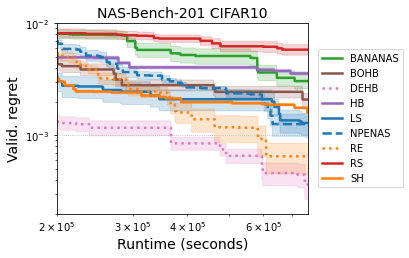

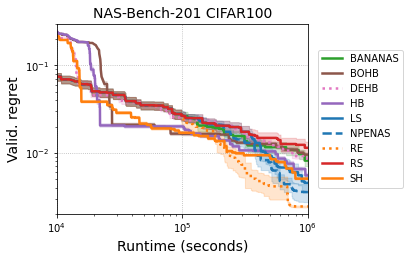

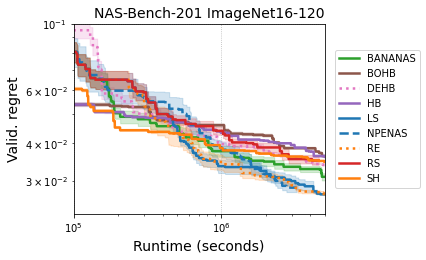

In [13]:
# plot performance vs runtime

for key_choice in results.keys():
    results_dict = results[key_choice]

    keys = predictors


    keys = sorted(keys)

    plt.rcParams['axes.grid'] = True
    plt.rcParams['grid.linestyle'] = 'dotted'
    add_sub_axes = False

    fig, ax = plt.subplots(figsize=[4.5, 3.5])
    if add_sub_axes:
        sub_axes = plt.axes([.6, .5, .3, .38]) 


    for i, key in enumerate(keys):
        mean = results_dict[key]['mean']
        sem = results_dict[key]['std_error']
        label = results_dict[key]['label']
        x = results_dict[key]['runtime']
        #tag = '_'.join(key.split('_')[:-1])
        tag = key
        color = pred_plot_dict[tag]['color']
        fmt = pred_plot_dict[tag]['fmt']
        ax.plot(x, mean, label=label, color=color, linestyle=fmt, linewidth=2.5)
        ax.fill_between(x, mean-50*sem, mean+50*sem,
                        color=color, alpha=0.2)

        if add_sub_axes:
            n = 450
            X_detail = x[n:]
            Y_detail = mean[n:]
            sem_detail = sem[n:]
            sub_axes.plot(X_detail, Y_detail, color=color, linestyle=fmt)
            sub_axes.tick_params(labelbottom=False) 

    ax.set_xlabel('Runtime (seconds)', fontsize=14)

    if key_choice == 'nasbenchnlp':
        ax.set_ylabel('Perplexity regret', fontsize=14) #nas201
    else:
        ax.set_ylabel('Valid. regret', fontsize=14) #nas201

    # ax.grid(True, which="both",ls="-", alpha=.5)

    if key_choice == 'cifar10':    
        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.set_ylim([2e-4, 1e-2])
        ax.set_xlim([2.0e5, 7.6*1e5])
        ax.legend(bbox_to_anchor=(1.04,0.5), loc="center left", borderaxespad=0)
        ax.set_title('NAS-Bench-201 CIFAR10', fontsize=14)
        save_path = os.path.join(result_folder, 'nas201_c10.pdf')
        plt.savefig(os.path.expanduser(save_path), bbox_inches = 'tight', pad_inches = 0.1)
    elif key_choice == 'cifar100':    
        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.set_ylim([0.0020, 0.3])
        ax.set_xlim([1e4, 1e6])
        ax.legend(bbox_to_anchor=(1.04,0.5), loc="center left", borderaxespad=0)
        ax.set_title('NAS-Bench-201 CIFAR100', fontsize=14)
        save_path = os.path.join(result_folder, 'nas201_c100.pdf')
        plt.savefig(os.path.expanduser(save_path), bbox_inches = 'tight', pad_inches = 0.1)
    elif key_choice == 'ImageNet16-120':    
        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.set_ylim([-0.2, 1e-1])
        # ax.set_ylim([0.0025, 0.3])
        ax.set_xlim([1.0e5, 5e6])
        ax.legend(bbox_to_anchor=(1.04,0.5), loc="center left", borderaxespad=0)
        ax.set_title('NAS-Bench-201 ImageNet16-120', fontsize=14, loc='right')
        save_path = os.path.join(result_folder, 'nas201_im.pdf')
        plt.savefig(os.path.expanduser(save_path), bbox_inches = 'tight', pad_inches = 0.1)
    elif key_choice == 'nasbench311':    
        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.set_ylim([.035, .066])
        ax.set_xlim([400, 2100])
        # ax.set_ylim([2e-3, .028])
        # ax.set_xlim([5e4, 4*10e5])
        ax.legend(ncol=2, loc=3, fontsize=8)
        ax.set_title('NAS-Bench-311 CIFAR10', fontsize=14)
        save_path = os.path.join(result_folder, 'nas311_c10.pdf')
        plt.show()
        plt.savefig(os.path.expanduser(save_path), bbox_inches = 'tight', pad_inches = 0.1)

    elif key_choice == 'nasbench111':
        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.set_ylim([4e-4, 8e-2])
        ax.set_xlim([2e4, 5.8*10e4])
        ax.legend(ncol=2, loc=3, fontsize=8)
        ax.set_title('NAS-Bench-111 CIFAR10', fontsize=14)
        save_path = os.path.join(result_folder, 'nas111_c10.pdf')
        plt.savefig(os.path.expanduser(save_path), bbox_inches = 'tight', pad_inches = 0.1)

    elif key_choice == 'nasbenchnlp':
        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.set_ylim([.5, 4.2e1])
        ax.set_xlim([5e4, 1.1*10e6])
        ax.legend(ncol=2, loc=3, fontsize=8)
        ax.set_title('NAS-Bench-NLP11 PTB', fontsize=14)
        save_path = os.path.join(result_folder, 'nasn11_ptb.pdf')
        plt.savefig(os.path.expanduser(save_path), bbox_inches = 'tight', pad_inches = 0.1)
